## Topicos de Modelos no Supervisados

### Deteccion de anomalias con Gaussian Mixture Model (GMM)



In [1]:
# Importacion de bibliotecas

import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
from sklearn.mixture import GaussianMixture #GMM
from sklearn.pipeline import make_pipeline 
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

## Datos

El set de datos geyser del paquete de **R MASS**, contiene información sobre las erupciones del géiser Old Faithful localizado en el parque nacional de Yellowstone, Wyoming. 

En concreto, recoge información sobre la duración de 299 erupciones, así como el tiempo transcurrido desde la anterior.

In [2]:
# Importando dataset

url = 'https://raw.githubusercontent.com/JoaquinAmatRodrigo/' \
      + 'Estadistica-machine-learning-python/master/data/geyser.csv'
datos_X = pd.read_csv(url)

In [3]:
# Inspeccionando Dataset

datos_X.head(5)

,waiting,duration
0,80,4.016667
1,71,2.150000
2,57,4.000000
3,80,4.000000
4,75,4.000000


In [4]:
datos_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   waiting   299 non-null    int64  
 1   duration  299 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 4.8 KB


In [5]:
## El Dataset es bastante pequeno, por lo que sera facil de manipular a nivel de graficos

In [6]:
# Visualizando si hay datos nulos

datos_X.isnull().sum()

# No hay datos nulos

waiting     0
duration    0
dtype: int64

In [7]:
# Comprobando si hay datos duplicados

datos_X.duplicated().sum() 

# Hay datos duplicados, pero como son duracion de erupciones es bastante probable que hayan algunas que duren lo mismo en promedio, 
# Por lo que no se depuraran.

42

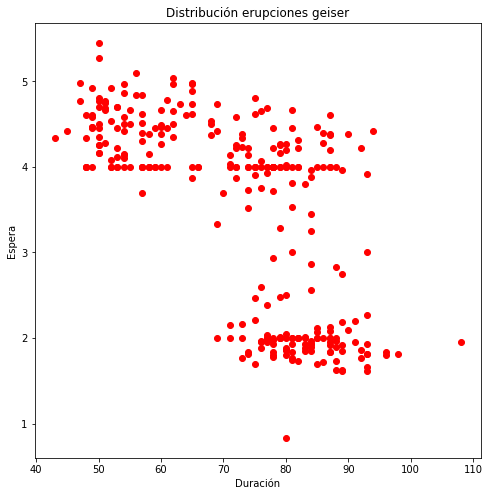

In [8]:
# Ploteando grafico para ver la distribucion de las variables

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
plt.scatter(datos_X.waiting, datos_X.duration, color = 'red')
plt.title('Distribución erupciones geiser')
plt.ylabel('Espera')
plt.xlabel('Duración')
plt.show()

### Modelo

En problemas con dos dimensiones (variables) como este, la identificación del número de componentes puede hacerse visualmente. Viendo los datos, parece razonable pensar que hay 3 grupos en los datos.

**¿Cómo saber el número de componentes y tipo de matriz de covarianza?**

Al tratarse de un problema no supervisado, no hay forma de conocer de antemano el número de componentes y tipo de matriz de covarianza óptimos. Afortunadamente, al ser un modelo probabilístico, se puede recurrir a métricas como el Akaike information criterion (AIC) o Bayesian information criterion (BIC) para identificar cómo de bien se ajustan los datos observados al modelo creado, a la vez que se controla el exceso de overfitting. En la implementación de Scikit Learn, para ambas métricas, cuanto más bajo el valor, mejor.

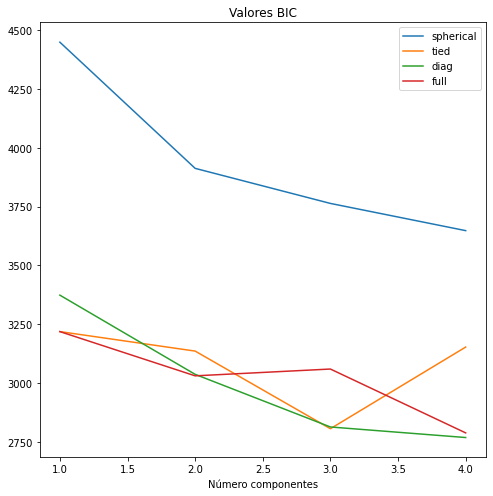

In [9]:
# Creando metrica BIC para ver con cuantos componentes es necesario tunnear el modelo

fig, ax = plt.subplots(figsize=(8, 8))

n_components = range(1, 5)
covariance_types = ['spherical', 'tied', 'diag', 'full']

for covariance_type in covariance_types:
    valores_bic = []
    
    for i in n_components:
        modelo = GaussianMixture(n_components=i, covariance_type=covariance_type)
        modelo = modelo.fit(datos_X)
        valores_bic.append(modelo.bic(datos_X))
        
    ax.plot(n_components, valores_bic, label=covariance_type)
        
ax.set_title("Valores BIC")
ax.set_xlabel("Número componentes")
ax.legend();

Viendo la métrica BIC, su valor se estabiliza a partir de las 3 componentes, lo que coincide con la idea obtenida en la inspección visual de los datos y su matriz de covarianza es de tipo Diag, ya que es el valor mas bajo. 

In [10]:
# Entrenamiento del modelo con la cantidad de componentes mostrado por la metrica BIC

modelo_gmm = GaussianMixture(
                n_components    = 3,
                covariance_type = 'diag',
                random_state    = 123, 
             )

modelo_gmm.fit(X=datos_X)

GaussianMixture(covariance_type='diag', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=123, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

### Prediccion de Probabilidades

In [11]:
log_probabilidad_predicha = modelo_gmm.score_samples(X=datos_X)

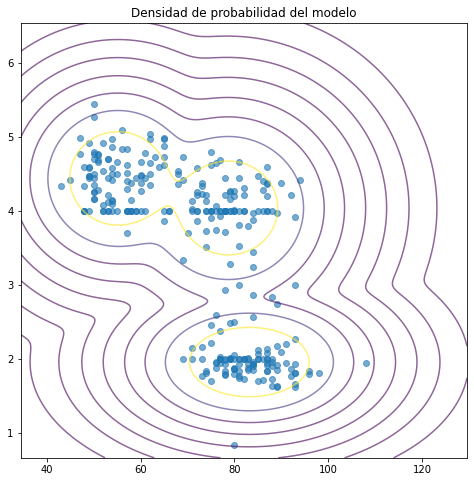

In [12]:
# Creando mapa de densidad de probabilidades posibles para los datos

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

# Grid de valores dentro del rango observado
x = np.linspace(min(datos_X.waiting)*0.8, max(datos_X.waiting)*1.2, 1000)
y = np.linspace(min(datos_X.duration)*0.8, max(datos_X.duration)*1.2, 1000)
xx, yy = np.meshgrid(x, y)

# Densidad de probabilidad de cada valor del grid
scores = modelo_gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
scores = np.exp(scores) # Los valores están en log

ax.scatter(datos_X.waiting, datos_X.duration, alpha=0.6)
ax.contour(
    xx, yy, scores.reshape(xx.shape), alpha=0.6,
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
ax.set_title('Densidad de probabilidad del modelo');

Podemos ver como se crean tres clusters y hay anomalias en cada uno de ellos que se escapan de los limites probables de cada uno de los clusters.

### Deteccion de Anomalias

Se van a identificar todas aquellas observaciones con menor probabilidad acorde al modelo. Para este caso vamos a trabajar con 10 anomalias detectables.

In [21]:
df_resultados = datos_X.copy()
df_resultados['log_proba'] = log_probabilidad_predicha
df_resultados = df_resultados.sort_values(by='log_proba')
top_anomalias = df_resultados.head(10)
top_anomalias

,waiting,duration,log_proba
148,80,0.833333,-14.168780
60,108,1.950000,-10.363347
242,93,3.000000,-10.010828
26,88,2.833333,-9.262396
269,89,2.750000,-8.861988
169,84,2.866667,-8.661795
11,50,5.450000,-8.160330
109,78,2.933333,-8.001557
83,81,3.000000,-7.592703
34,76,2.600000,-7.392119


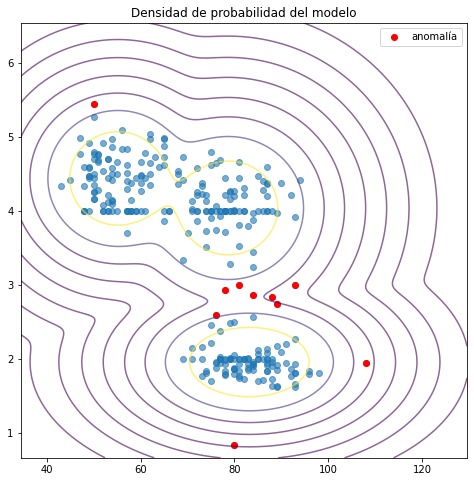

In [22]:
# Mapa de densidad de probabilidad en el que se detectan las anomalias

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))

# Grid de valores dentro del rango observado
x = np.linspace(min(datos_X.waiting)*0.8, max(datos_X.waiting)*1.2, 1000)
y = np.linspace(min(datos_X.duration)*0.8, max(datos_X.duration)*1.2, 1000)
xx, yy = np.meshgrid(x, y)

# Densidad de probabilidad de cada valor del grid
scores = modelo_gmm.score_samples(np.c_[xx.ravel(), yy.ravel()])
scores = np.exp(scores) # Los valores están en log

ax.scatter(datos_X.waiting, datos_X.duration, alpha=0.6)
ax.scatter(top_anomalias.waiting, top_anomalias.duration, c="red", label='anomalía')
ax.contour(
    xx, yy, scores.reshape(xx.shape),
    alpha=0.6, cmap='viridis',
    levels=np.percentile(scores, np.linspace(0, 100, 10))[1:-1]
)
ax.set_title('Densidad de probabilidad del modelo');
ax.legend();

Una de las principales limitaciones del uso de modelos GMM como detectores de anomalías es que consideran que los datos siguen distribuciones normales multivariante. En la práctica, esta asunción es difícil que se cumpla, sobretodo a medida que aumenta el número de variables. Una estrategia que en ocasiones consigue mitigar parte de este problema es reducir la dimensionalidad de los datos con PCA y luego aplicar un modelo GMM con solo unas pocas componentes.